## a notebook to test setting up a custom sampling step

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

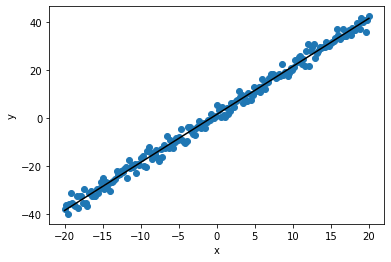

In [12]:
# generate test data, a linear system

b = [2,1.5]
sigma = 2

n = 200
x = np.linspace(start=-20,stop = 20, num = n)
y = b[0]*x+b[1]
y_obs = y + sigma*np.random.randn(n)

plt.plot(x,y,'k')
plt.scatter(x,y_obs)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## First, sample through pymc3 built in samplers

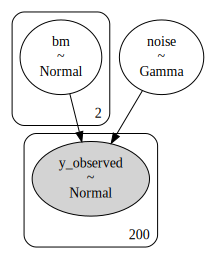

In [13]:
with pm.Model() as linear_model:

    bm = pm.Normal("bm", mu=0, sigma=2,shape=2)
    noise = pm.Gamma("noise", alpha=2, beta=1)

    y_observed = pm.Normal("y_observed",mu=bm[0]*x+bm[1],sigma=noise,observed=y_obs)
pm.model_to_graphviz(linear_model)

In [14]:
posterior = pm.sample(model = linear_model,chains=2, draws=3000, tune=1000,return_inferencedata=True)

az.summary(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\stephan\miniconda3\envs\pymc3\lib\site-packages\aesara\graph\fg.py:525: UserWarning: Variable Elemwise{mul,no_inplace}.0 cannot be replaced; it isn't in the FunctionGraph
  warnings.warn(
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [noise, bm]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bm[0],1.997,0.012,1.974,2.020,0.000,0.000,8291.0,4420.0,1.0
bm[1],1.496,0.140,1.227,1.753,0.002,0.001,8685.0,4746.0,1.0
noise,1.984,0.102,1.792,2.167,0.001,0.001,7499.0,4038.0,1.0


## second, sample manually from a Gaussian

In [21]:
def my_sampler(mu=0,sigma=2):
    b = np.random.normal(mu,sigma,2)

    return b

In [35]:
my_sampler()

array([1.38329165, 1.63748349])

In [60]:
class MySamplingStep(object):
    def __init__(self, var, mu, sigma):
            self.vars = var
            self.mu = mu
            self.sigma = sigma

    def step(self, point: dict):
        new = point.copy()
        new[self.var] = my_sampler(self.mu,self.sigma)

        return new

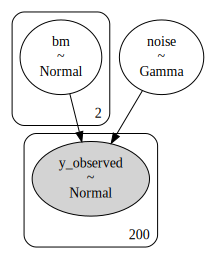

In [65]:
mu = 0
sigma = 2

with pm.Model() as my_linear_model:
    bm = pm.Normal("bm", mu=0, sigma=2,shape=2)
    step_bm = MySamplingStep(bm, mu, sigma)
    noise = pm.Gamma("noise", alpha=2, beta=1)

    y_observed = pm.Normal("y_observed",mu=bm[0]*x+bm[1],sigma=noise,observed=y_obs)


pm.model_to_graphviz(my_linear_model)

In [66]:
posterior2 = pm.sample(model = my_linear_model,step = [step_bm], chains=2, draws=3000, tune=1000,return_inferencedata=True)

az.summary(posterior2)

ValueError: Length of bm ~ Normal cannot be determined